# Frictionless Pendulum on a Cart (No Forcing)

## Imports & Symbols

In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sympy as sp

np.set_printoptions(precision=4)
plt.rcParams["figure.figsize"] = (20, 12)

In [2]:
t, g = sp.symbols("t g")
l, m, M = sp.symbols("l m M")

theta = sp.Function("theta")
x = sp.Function("x")

# Physical Modeling

## Kinematics

In [3]:
x_p = x(t) + l * sp.sin(theta(t))
x_p

l*sin(theta(t)) + x(t)

In [4]:
y_p = -l * sp.cos(theta(t))
y_p

-l*cos(theta(t))

In [5]:
x_p_dot = x_p.diff(t)
x_p_dot

l*cos(theta(t))*Derivative(theta(t), t) + Derivative(x(t), t)

In [6]:
y_p_dot = y_p.diff(t)
y_p_dot

l*sin(theta(t))*Derivative(theta(t), t)

## Potential Energy

There's only the gravitational potential energy, which acts in the `y` direction.

$$
V = m \cdot g \cdot y = - m \cdot g \cdot l \cdot cos(\theta)
$$

In [7]:
V = -m * g * l * sp.cos(theta(t))
V

-g*l*m*cos(theta(t))

## Kinectic Energy

There are two Kinectic energies, one related to the Cart and one on the Pendulum mass. The total energy is the sum of both.

Since the pendulum moves in two coordinates, it can be modeled as two separate kinectic energies.

$$
T = \frac{1}{2} \cdot M \cdot \dot{x}^2 + \frac{1}{2} \cdot m \cdot \dot{x}_p^2 + \frac{1}{2} \cdot m \cdot \dot{y}_p^2
$$

$$
T = \frac{1}{2} \cdot M \cdot \dot{x}^2 + \frac{1}{2} \cdot m \cdot (\dot{x}_p^2 + \dot{y}_p^2)
$$

In [8]:
T = sp.Rational(1, 2) * M * (x(t).diff(t) ** 2) + sp.Rational(1, 2) * m * (
    x_p_dot**2 + y_p_dot**2
)
T.simplify()

M*Derivative(x(t), t)**2/2 + m*(l**2*Derivative(theta(t), t)**2 + 2*l*cos(theta(t))*Derivative(theta(t), t)*Derivative(x(t), t) + Derivative(x(t), t)**2)/2

## Lagrangian and Equations of Motion

In [9]:
L = T - V
L

M*Derivative(x(t), t)**2/2 + g*l*m*cos(theta(t)) + m*(l**2*sin(theta(t))**2*Derivative(theta(t), t)**2 + (l*cos(theta(t))*Derivative(theta(t), t) + Derivative(x(t), t))**2)/2

In [10]:
x_motion_eq, theta_motion_eq = sp.euler_equations(L, [x(t), theta(t)], t)

In [11]:
x_motion_eq

Eq(-M*Derivative(x(t), (t, 2)) - m*(-l*sin(theta(t))*Derivative(theta(t), t)**2 + l*cos(theta(t))*Derivative(theta(t), (t, 2)) + Derivative(x(t), (t, 2))), 0)

In [12]:
theta_motion_eq.simplify()

Eq(l*m*(g*sin(theta(t)) + l*Derivative(theta(t), (t, 2)) + cos(theta(t))*Derivative(x(t), (t, 2))), 0)

# Coupled Equations

In the previous section, both Euler-Lagrange equations of motion are coupled to each other's second order derivative:

$$
\ddot{x} = f(t, x, \dot{x}, \ddot{x}, \theta, \dot{\theta}, \ddot{\theta}) \\
\ddot{\theta} = f(t, x, \dot{x}, \ddot{x}, \theta, \dot{\theta}, \ddot{\theta})
$$

Before linearizing them, It's necessary to solve the system so that it's possible to write $\ddot{x}$ and $\ddot{\theta}$ as only functions of lower order derivatives:

$$
\ddot{x} = f(t, x, \dot{x}, \theta, \dot{\theta}) \\
\ddot{\theta} = f(t, x, \dot{x}, \theta, \dot{\theta})
$$


In [13]:
sols = sp.solve(
    [x_motion_eq, theta_motion_eq], [x(t).diff(t, 2), theta(t).diff(t, 2)]
)

In [14]:
x_ddot = sols[x(t).diff(t, 2)].simplify()
x_ddot

m*(g*cos(theta(t)) + l*Derivative(theta(t), t)**2)*sin(theta(t))/(M + m*sin(theta(t))**2)

In [15]:
theta_ddot = sols[theta(t).diff(t, 2)].simplify()
theta_ddot

-(M*g + g*m + l*m*cos(theta(t))*Derivative(theta(t), t)**2)*sin(theta(t))/(l*(M + m*sin(theta(t))**2))

# Linearization

From the previous section, it's possible to write the system of equations in this format:

$$
\frac{d}{dt} \begin{bmatrix}
  x \\
  \dot{x} \\
  \theta \\
  \dot{\theta}
\end{bmatrix}
= \begin{bmatrix}
  f_1(t, x, \dot{x}, \theta, \dot{\theta}) \\
  f_2(t, x, \dot{x}, \theta, \dot{\theta}) \\
  f_3(t, x, \dot{x}, \theta, \dot{\theta}) \\
  f_4(t, x, \dot{x}, \theta, \dot{\theta})
\end{bmatrix}
= \begin{bmatrix}
  \dot{x} \\
  \ddot{x} \\ 
  \dot{\theta} \\
  \ddot{\theta}
\end{bmatrix}
$$

## Jacobian Matrix

The first step to linearize this sytems is to compute the Jacobian matrix:

$$
\frac{D_f}{D_x} = \begin{bmatrix}
    \frac{\partial f_1}{\partial x} & \frac{\partial f_1}{\partial \dot{x}} & \frac{\partial f_1}{\partial \theta} & \frac{\partial f_1}{\partial \dot{\theta}} \\[0.5em]
    \frac{\partial f_2}{\partial x} & \frac{\partial f_2}{\partial \dot{x}} & \frac{\partial f_2}{\partial \theta} & \frac{\partial f_2}{\partial \dot{\theta}} \\[0.5em]
    \frac{\partial f_3}{\partial x} & \frac{\partial f_3}{\partial \dot{x}} & \frac{\partial f_3}{\partial \theta} & \frac{\partial f_3}{\partial \dot{\theta}} \\[0.5em]
    \frac{\partial f_4}{\partial x} & \frac{\partial f_4}{\partial \dot{x}} & \frac{\partial f_4}{\partial \theta} & \frac{\partial f_4}{\partial \dot{\theta}}
\end{bmatrix}
$$

In [16]:
eq_system = sp.Matrix([x(t).diff(t), x_ddot, theta(t).diff(t), theta_ddot])
eq_system

Matrix([
[                                                                                   Derivative(x(t), t)],
[             m*(g*cos(theta(t)) + l*Derivative(theta(t), t)**2)*sin(theta(t))/(M + m*sin(theta(t))**2)],
[                                                                               Derivative(theta(t), t)],
[-(M*g + g*m + l*m*cos(theta(t))*Derivative(theta(t), t)**2)*sin(theta(t))/(l*(M + m*sin(theta(t))**2))]])

In [17]:
vars = [x(t), x(t).diff(t), theta(t), theta(t).diff(t)]
jacobian = eq_system.jacobian(vars)
jacobian

Matrix([
[0, 1,                                                                                                                                                                                                                                                                                                              0,                                                                                 0],
[0, 0,                                                -g*m*sin(theta(t))**2/(M + m*sin(theta(t))**2) - 2*m**2*(g*cos(theta(t)) + l*Derivative(theta(t), t)**2)*sin(theta(t))**2*cos(theta(t))/(M + m*sin(theta(t))**2)**2 + m*(g*cos(theta(t)) + l*Derivative(theta(t), t)**2)*cos(theta(t))/(M + m*sin(theta(t))**2),              2*l*m*sin(theta(t))*Derivative(theta(t), t)/(M + m*sin(theta(t))**2)],
[0, 0,                                                                                                                                                                                                   

## Fixed Point

In [18]:
fixed_point = {x(t): 0, x(t).diff(t): 0, theta(t): sp.pi, theta(t).diff(t): 0}

In [19]:
jacobian.subs(fixed_point)

Matrix([
[0, 1,                 0, 0],
[0, 0,             g*m/M, 0],
[0, 0,                 0, 1],
[0, 0, (M*g + g*m)/(M*l), 0]])

# Simulation

In [20]:
def non_linear_system(t, y, m: float, M: float, l: float, g: float):
    x_t, v_t, theta_t, theta_dot_t = y

    sin_theta_t = np.sin(theta_t)
    cos_theta_t = np.cos(theta_t)

    v_N = m * (g * cos_theta_t + l * (theta_dot_t**2)) * sin_theta_t
    v_D = M + m * (sin_theta_t**2)
    v_dot_t = v_N / v_D

    t_ddot_N = (
        M * g + g * m + l * m * cos_theta_t * (theta_dot_t**2)
    ) * sin_theta_t
    t_ddot_D = l * (M + m * (sin_theta_t**2))
    theta_ddot_t = -t_ddot_N / t_ddot_D

    return np.array([v_t, v_dot_t, theta_dot_t, theta_ddot_t])

In [21]:
args = (0.005, 0.2, 300, 9807)
init = [0, 0, math.radians(15), 0]
t = np.arange(0, 7, 0.01)
nl_solution = scipy.integrate.solve_ivp(
    non_linear_system, (0, 7), init, t_eval=t, args=args
)

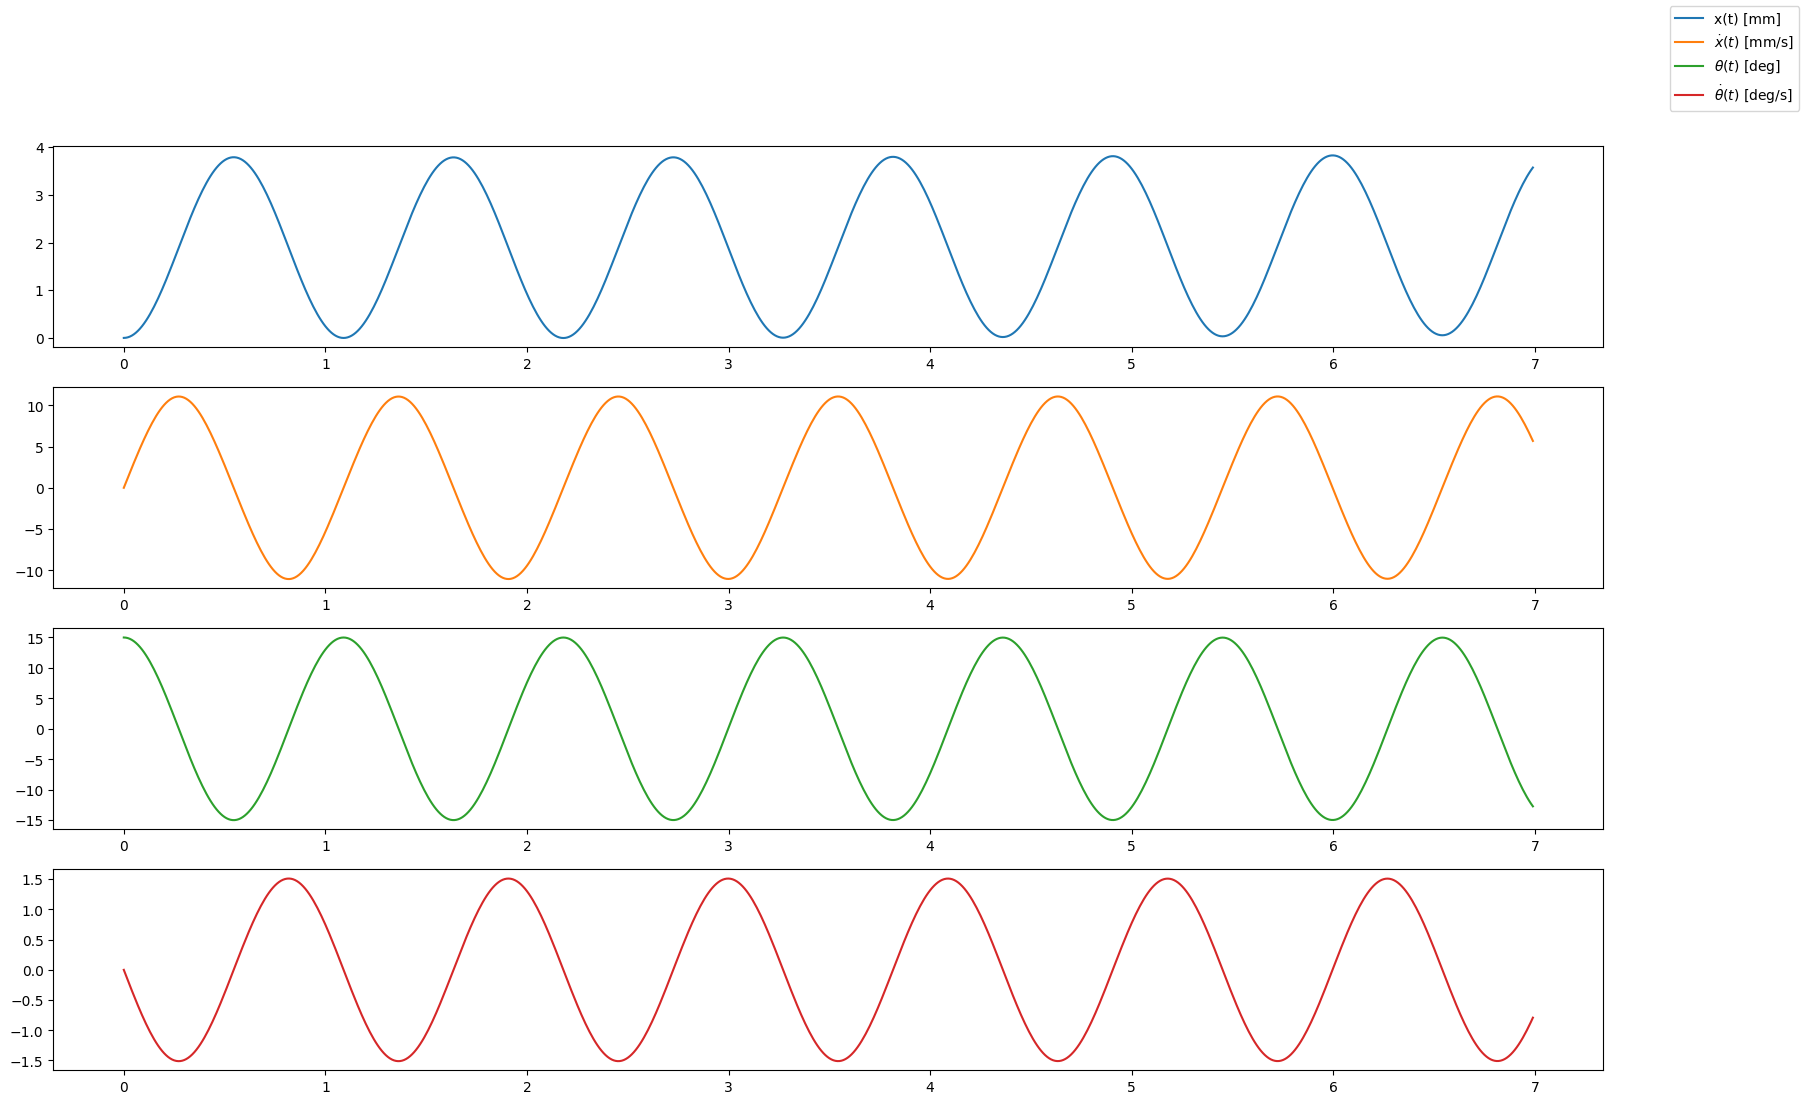

In [22]:
fig, ax = plt.subplots(nrows=4, ncols=1)
ax[0].plot(nl_solution.t, nl_solution.y[0], "C0", label="x(t) [mm]")
ax[1].plot(nl_solution.t, nl_solution.y[1], "C1", label=r"$\dot{x}(t)$ [mm/s]")
ax[2].plot(
    nl_solution.t,
    np.rad2deg(nl_solution.y[2]),
    "C2",
    label=r"$\theta(t)$ [deg]",
)
ax[3].plot(
    nl_solution.t, nl_solution.y[3], "C3", label=r"$\dot{\theta}(t)$ [deg/s]"
)
fig.legend()
plt.show()

## Comparison

In [23]:
rec_df = pd.read_csv("recordings/cart_2023-06-19_22:22:25.csv")
rec_df.index = pd.Index(rec_df.index * rec_df["interval"])
rec_df.tail()

,ts,interval,angle,angular_velocity,cart_friction,cart_x,cart_velocity,impulse,input_left,input_right
6.916667,1.687224e+09,0.002083,-0.143502,-1.262535,0.0,2.940500,9.071470,0.0,False,False
6.918750,1.687224e+09,0.002083,-0.146111,-1.252549,0.0,2.959399,8.994369,0.0,False,False
6.920833,1.687224e+09,0.002083,-0.148699,-1.242383,0.0,2.978137,8.916002,0.0,False,False
6.922917,1.687224e+09,0.002083,-0.151266,-1.232038,0.0,2.996712,8.836384,0.0,False,False
6.925000,1.687224e+09,0.002083,-0.153811,-1.221517,0.0,3.015121,8.755531,0.0,False,False


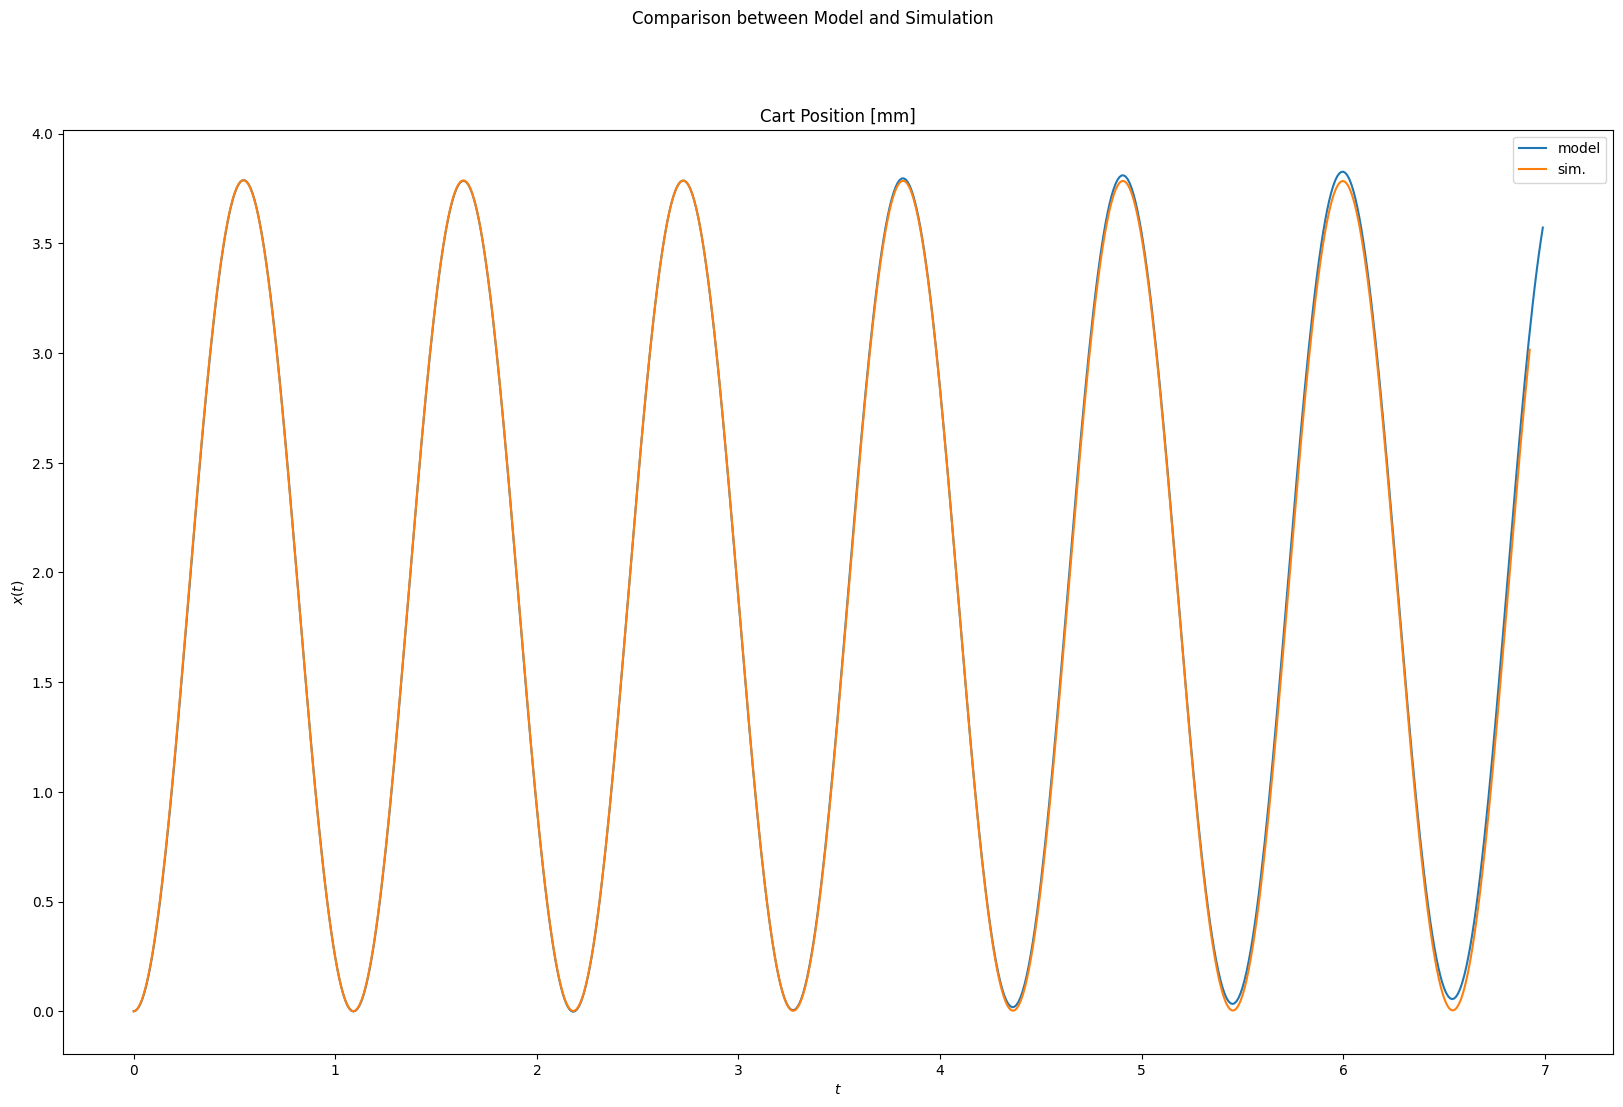

In [24]:
plt.plot(nl_solution.t, nl_solution.y[0], "C0", label="model")
plt.plot(rec_df.index, rec_df["cart_x"], "C1", label="sim.")
plt.legend()
plt.title("Cart Position [mm]")
plt.suptitle("Comparison between Model and Simulation")
plt.xlabel("$t$")
plt.ylabel("$x(t)$")
plt.show()

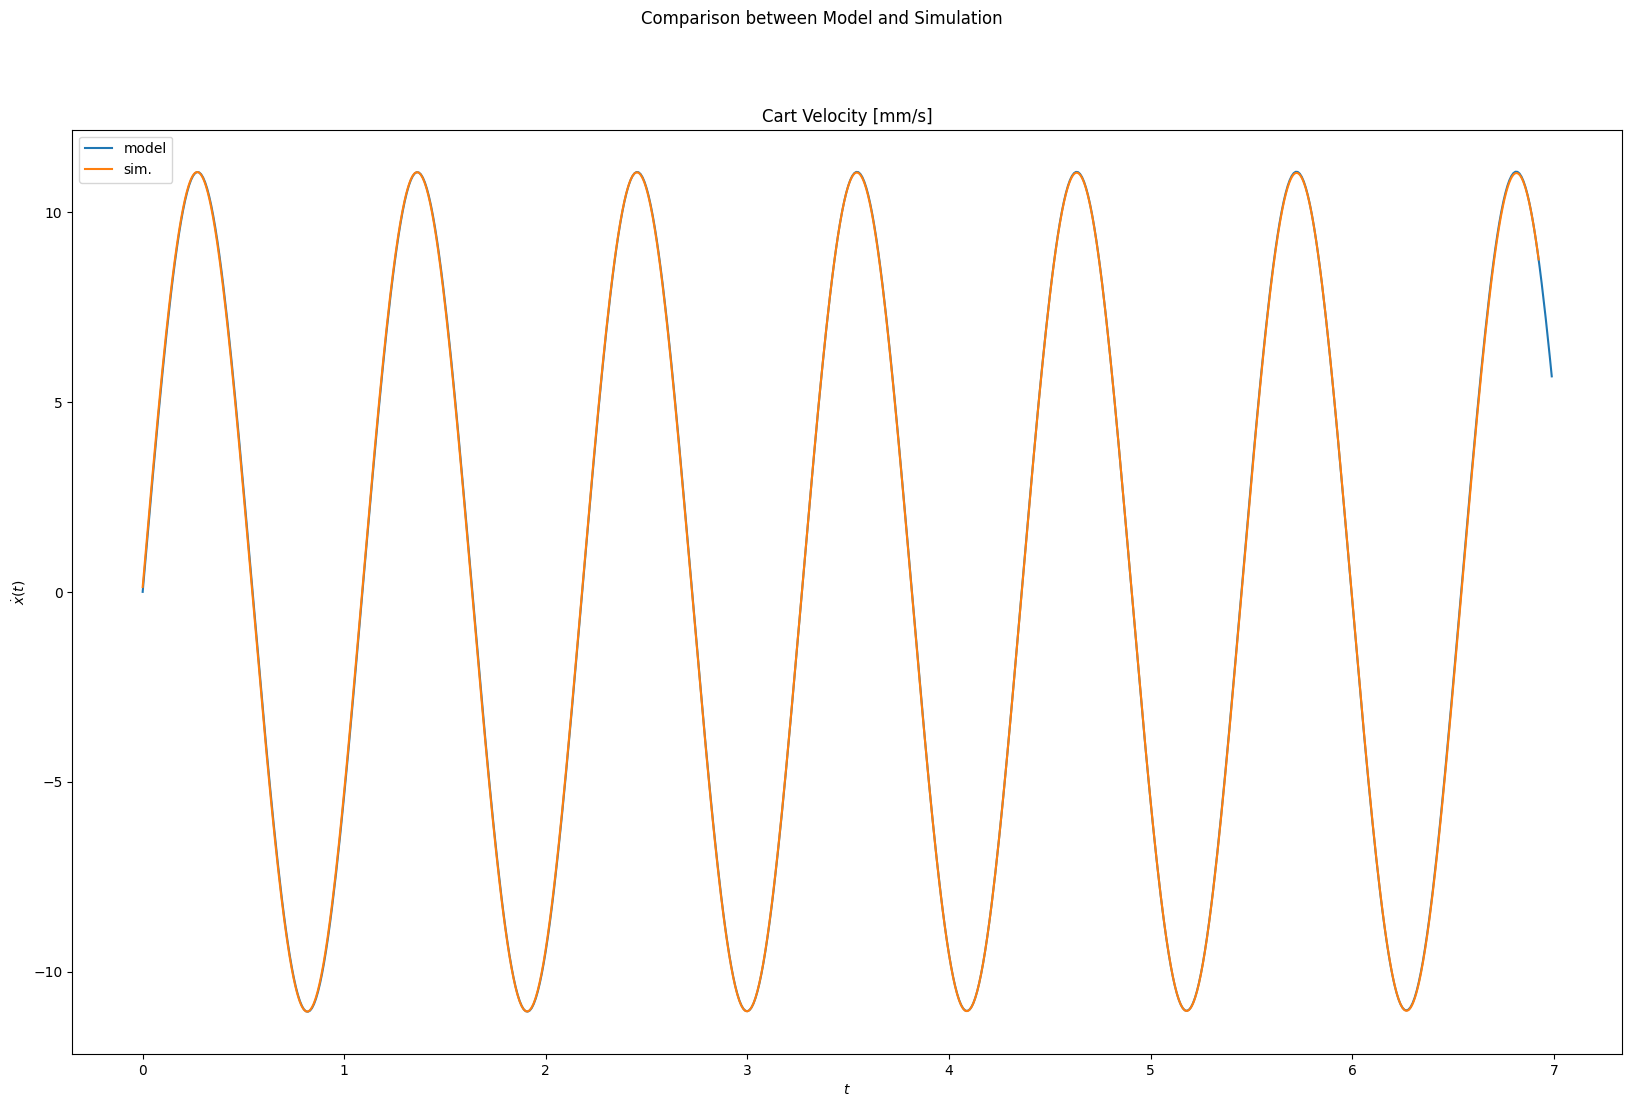

In [25]:
plt.plot(nl_solution.t, nl_solution.y[1], "C0", label="model")
plt.plot(rec_df.index, rec_df["cart_velocity"], "C1", label="sim.")
plt.legend()
plt.title("Cart Velocity [mm/s]")
plt.suptitle("Comparison between Model and Simulation")
plt.xlabel("$t$")
plt.ylabel("$\dot{x}(t)$")
plt.show()

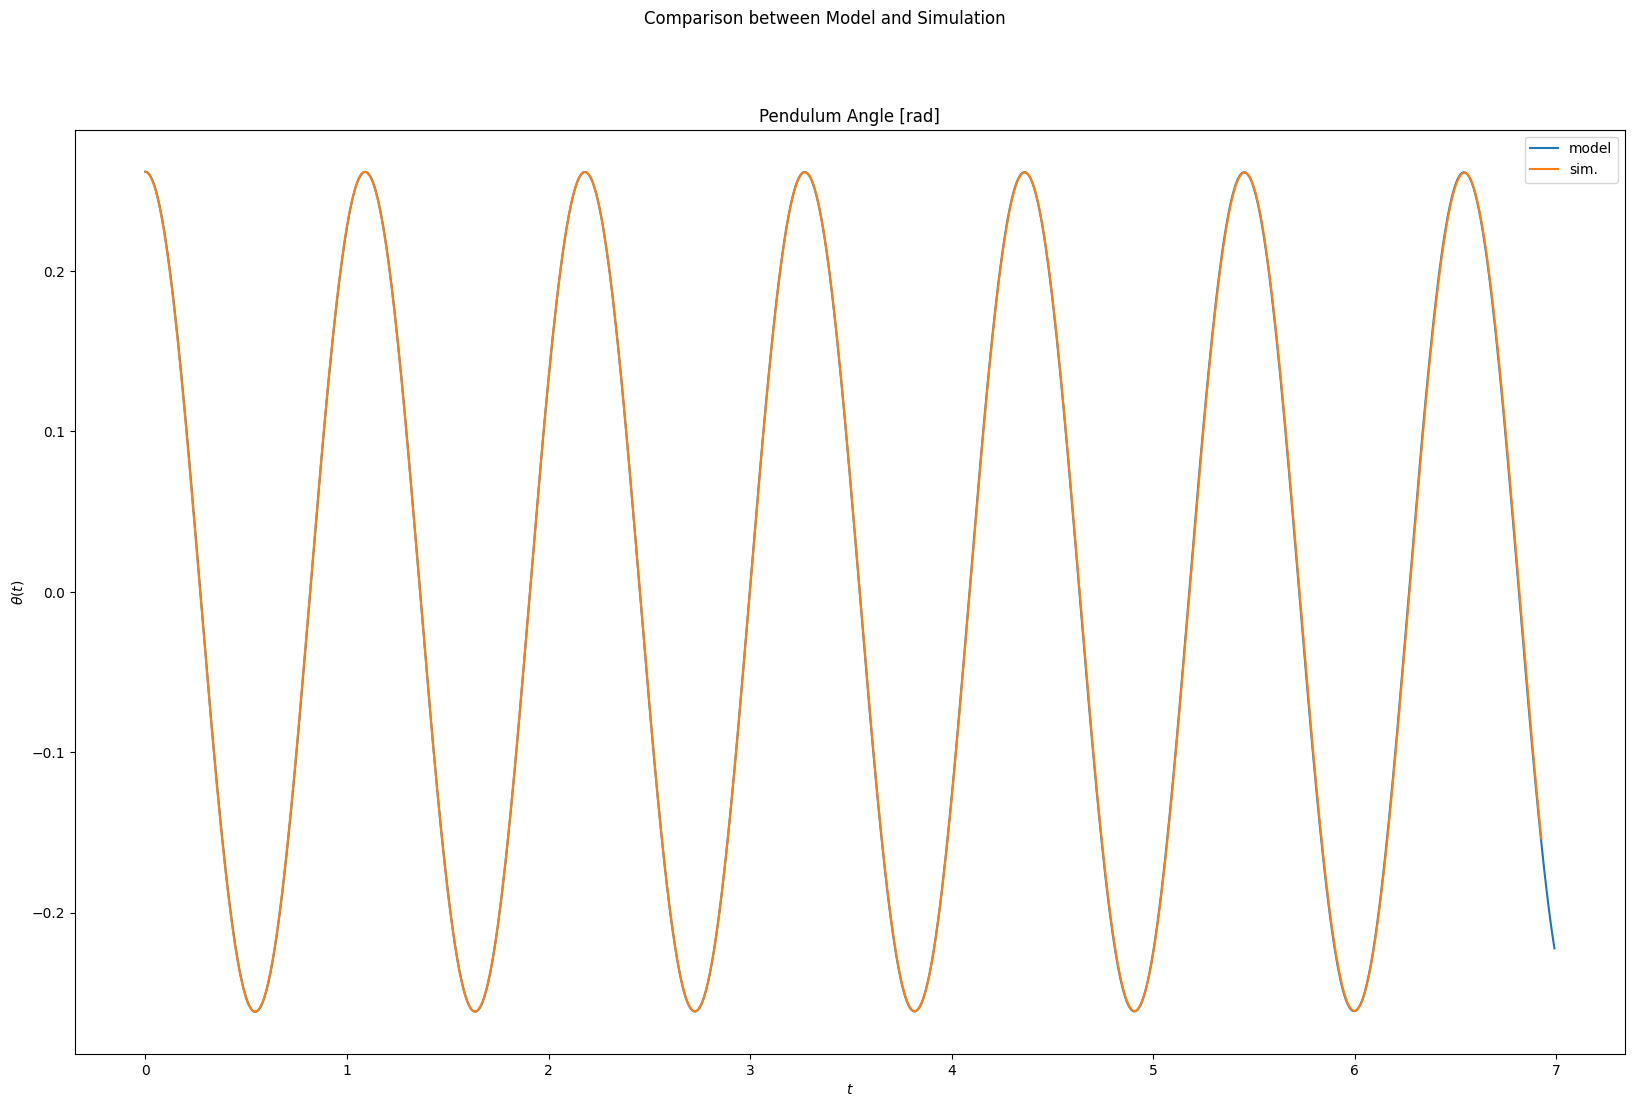

In [26]:
plt.plot(nl_solution.t, nl_solution.y[2], "C0", label="model")
plt.plot(rec_df.index, rec_df["angle"], "C1", label="sim.")
plt.legend()
plt.title("Pendulum Angle [rad]")
plt.suptitle("Comparison between Model and Simulation")
plt.xlabel("$t$")
plt.ylabel(r"$\theta(t)$")
plt.show()

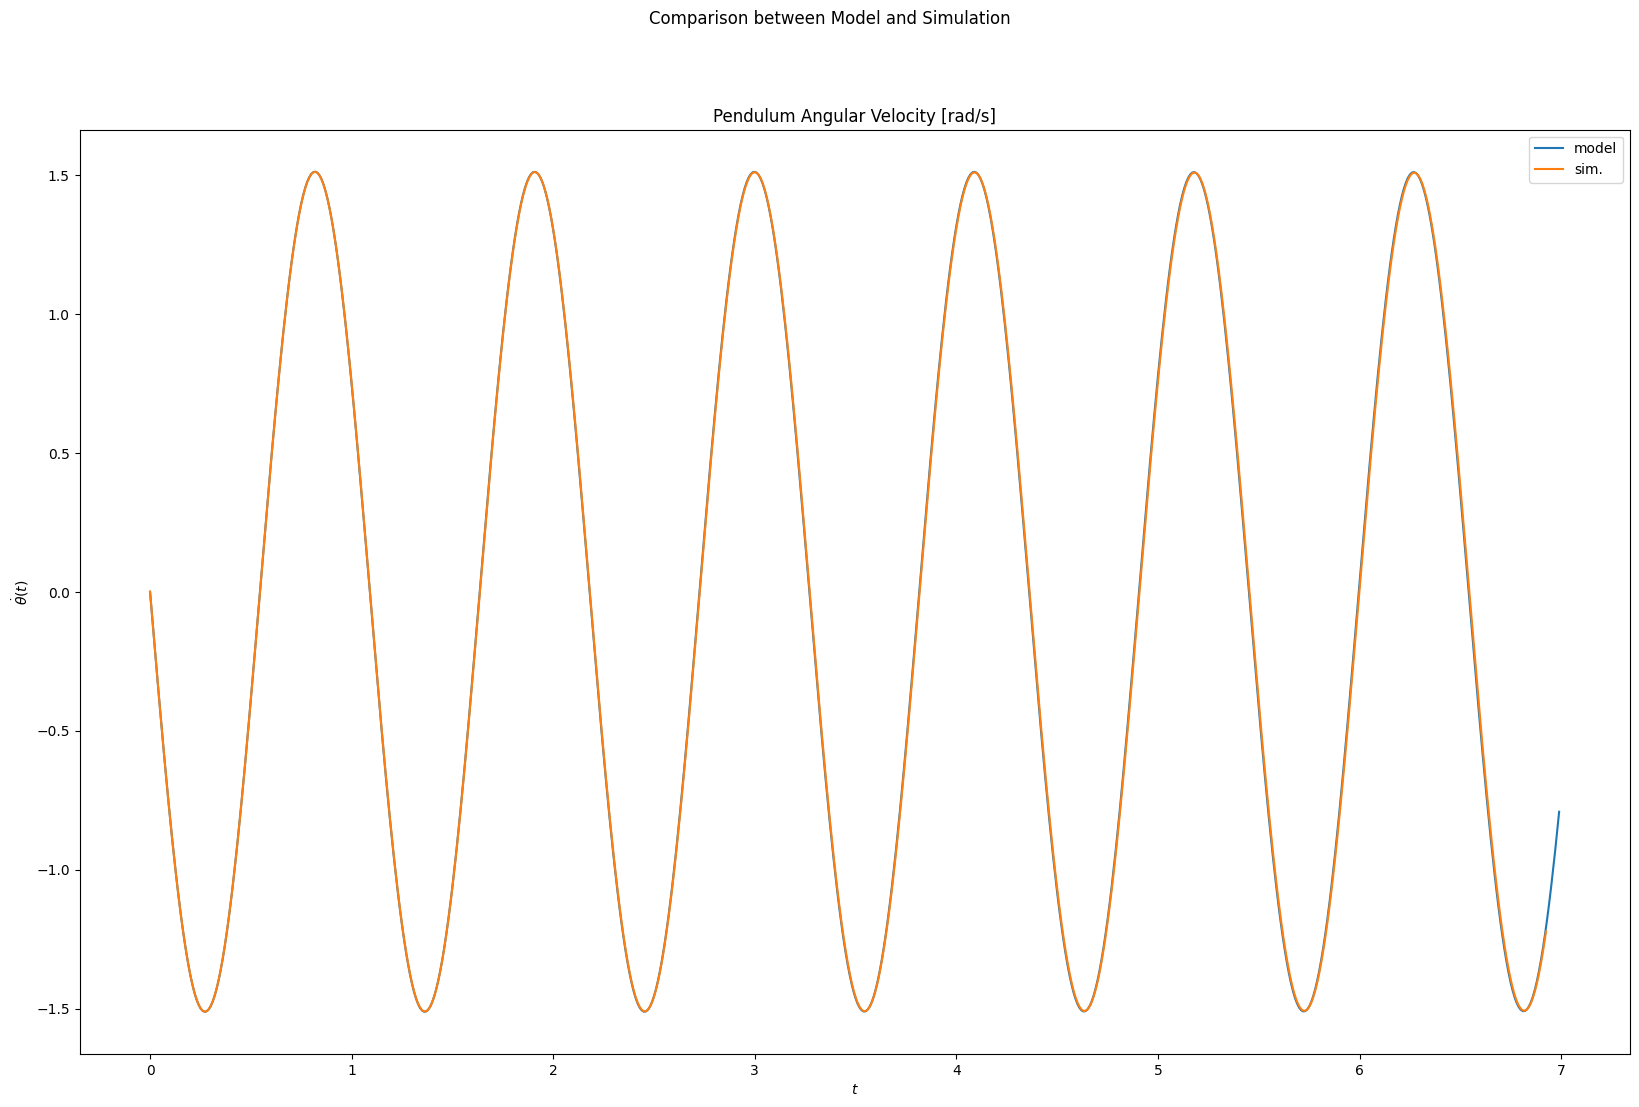

In [27]:
plt.plot(nl_solution.t, nl_solution.y[3], "C0", label="model")
plt.plot(rec_df.index, rec_df["angular_velocity"], "C1", label="sim.")
plt.legend()
plt.title("Pendulum Angular Velocity [rad/s]")
plt.suptitle("Comparison between Model and Simulation")
plt.xlabel("$t$")
plt.ylabel(r"$\dot{\theta}(t)$")
plt.show()